In [1]:
import os
import gc
import time

import pyreadr as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:5


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [4]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
# print("Objects that are present in a3 :", a3.keys())
# print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [5]:
# concatinating the train and the test dataset

raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])

In [6]:
# 5.250.000, 10.080.000
len(raw_train)

5250000

> ### Train-test-split

In [7]:
features = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
        'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
        'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
        'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
        'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
        'xmv_10', 'xmv_11'
    ]

In [8]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1

In [9]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

In [10]:
X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [11]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)

> ### Scaling

In [12]:
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])

> ### Dataset and dataloader

In [13]:
def correct(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

In [83]:
class DataTEP(Dataset):

    def __init__(self, X, kind):
    
        self.X = X
        self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
        self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
        self.X = self.X.set_index('index')
        
        self.max_length = self.X['sample'].max()
        
#         self.s_list = [20, 100, 200, 300, 400]
#         self.l_list = [1, 5, 10, 25, 50, 100]
#         self.l_list = [10, 50]

        if kind == 'train_val':
            self.s_list = [20]
            self.l_list = [50, 51] # !!!!!
        else:
            self.s_list = [0]
            self.l_list = list(range(160, self.max_length + 1))
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique() * len(self.s_list) * len(self.l_list)
    
    def __getitem__(self, idx):
        
        fault_sim_idx = idx // (len(self.s_list) * len(self.l_list))
    
        start_length_idxs = idx % (len(self.s_list) * len(self.l_list))
        
        start_idx = self.s_list[start_length_idxs // len(self.l_list)]
        seq_length = self.l_list[start_length_idxs % len(self.l_list)]

        features = self.X.loc[fault_sim_idx][self.features].values[start_idx : (start_idx+seq_length), :]
        target = self.X.loc[fault_sim_idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [238]:
BATCH_SIZE = 64
NUM_CLASSES = 21

In [239]:
def collate_fn(batch):

    sequences = [x[0] for x in batch]
    labels = [x[1] for x in batch]
        
    lengths = torch.LongTensor([len(x) for x in sequences])
    lengths, idx = lengths.sort(0, descending=True)
    
    sequences = [sequences[i] for i in idx]
    
    labels = torch.tensor(labels, dtype=torch.long)[idx]
    
    sequences_padded = pad_sequence(sequences, batch_first=True)

    return sequences_padded, lengths, labels

In [240]:
train_ds = DataTEP(X_train, kind='train_val')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

val_ds = DataTEP(X_val, kind='train_val')
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

# test_ds = DataTEP(X_test, kind='test')
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

In [241]:
len(train_ds), len(val_ds)
# len(test_ds)

(16800, 4200)

In [242]:
gc.collect()

823

> ### Model

In [274]:
class UniRNN(torch.nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        if RNN_TYPE == "lstm":
            self.rnn = nn.LSTM(
                            input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            bidirectional=self.bidirectional,
                            batch_first=True,
                            dropout=0.4
                )
        else:
            self.rnn = nn.GRU(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
            
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x, x_length):
        
        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        x_rnn_out, _ = self.rnn(x_packed)
        x_unpacked, _ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        idx_last_hidden = (x_length - 1).view(-1, 1).expand(len(x_length), x_unpacked.size(2)).unsqueeze(1)
        idx_last_hidden = idx_last_hidden.to(x.device)
        x_last_hiddens = x_unpacked.gather(1, idx_last_hidden).squeeze(1)
        
        x = self.head(x_last_hiddens)
        
        return x

In [278]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

NUM_LAYERS = 2
HIDDEN_SIZE = 256
LINEAR_SIZE = 128
BIDIRECTIONAL = True

In [279]:
model = UniRNN(RNN_TYPE='gru', NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
                 LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, DEVICE=device)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)

torch.manual_seed(42)
np.random.seed(42)

In [280]:
for i, (X_batch, X_lengths, y_batch) in enumerate(train_dl):
    if i < 1:
#         print(type(X_batch), type(X_lengths), type(y_batch))
#         print(len(X_batch), len(X_lengths), len(y_batch))
        print(X_lengths)
        X_batch, y_batch_train = X_batch.to(device), y_batch.to(device)
        y_pred_train = model(X_batch, X_lengths)
#         print("y_batch_train.size()", y_batch.size())
#         print("y_pred_train.size()", y_pred_train.size(), '\n')
    else:
        break

tensor([51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50])


In [281]:
# !rm -r runs

> ### Training

In [282]:
# writer = SummaryWriter(comment=f'NL{NUM_LAYERS}_H{HIDDEN_SIZE}_L{LINEAR_SIZE}_B{BIDIRECTIONAL}_S{-100}')

# writer = SummaryWriter(comment=f'lstm_20')
from datetime import datetime

writer = SummaryWriter(
    log_dir=f"gru_multiple_length/{datetime.today().strftime('%d%b-%H-%M')}"
    )

In [283]:
loss_train_all, loss_val_all = [], []
accuracy_train_all, accuracy_val_all = [], []

best_model_acc = 0
best_model_epoch = 0

for epoch in range(NUM_EPOCHS):

    start = time.time()
    print(f'Epoch: {epoch}, Learning Rate: {scheduler.get_last_lr()[0]}\n')
#     print(f'Epoch: {epoch}\n')

    loss_train_epoch, loss_val_epoch = 0, 0
    correct_train_epoch, correct_val_epoch = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for (X_batch_train, X_batch_lengths_train, y_batch_train) in tqdm(train_dl):

        X_batch_train, X_batch_lengths_train, y_batch_train =\
                    X_batch_train.to(device), X_batch_lengths_train.to(device), y_batch_train.to(device)

        optimizer.zero_grad()
        y_pred_train = model(X_batch_train, X_batch_lengths_train)
        loss_train = criterion(y_pred_train, y_batch_train)
        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item() * y_batch_train.size()[0]
        correct_train_epoch += correct(y_pred_train, y_batch_train)
        n_train += y_batch_train.size()[0]

    scheduler.step()
    model.eval()

    with torch.no_grad():
        
        for item in model.parameters():
            print(item.grad.mean())
        
        for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

            X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

            y_pred_val = model(X_batch_val, X_batch_lengths_val)
            loss_val = criterion(y_pred_val, y_batch_val)
            
            loss_val_epoch += loss_val.item() * y_batch_val.size()[0]
            correct_val_epoch += correct(y_pred_val, y_batch_val)
            n_val += y_batch_val.size()[0]
            

    loss_mean_train_epoch = loss_train_epoch / n_train
    loss_mean_val_epoch = loss_val_epoch / n_val

    loss_train_all.append(loss_mean_train_epoch)
    loss_val_all.append(loss_mean_val_epoch)

    accuracy_train_epoch = correct_train_epoch / n_train
    accuracy_val_epoch = correct_val_epoch / n_val

    accuracy_train_all.append(accuracy_train_epoch)
    accuracy_val_all.append(accuracy_val_epoch)

    writer.add_scalars('LOSS per epoch', {"train": loss_mean_train_epoch, "val": loss_mean_val_epoch}, epoch)
    writer.add_scalars('ACCURACY per epoch', {"train": accuracy_train_epoch, "val": accuracy_val_epoch}, epoch)
    
    if accuracy_val_epoch > best_model_acc:
        
        best_model_state_dict = model.state_dict()
        best_model_acc = accuracy_val_epoch
        best_model_epoch = epoch
        
#     scheduler.step(loss_mean_val_epoch)
    
    end = time.time()
    print(f"epoch time: {end - start}")  
    print(f"mean loss train: {loss_mean_train_epoch}, mean loss val: {loss_mean_val_epoch}")
    print(f"accuracy train: {accuracy_train_epoch}, accuracy val: {accuracy_val_epoch}")

    print("---------------------------------------------------------------------------------------------------")

Epoch: 0, Learning Rate: 0.001




tensor(1.0742e-05, device='cuda:5')
tensor(6.6437e-07, device='cuda:5')
tensor(6.1831e-06, device='cuda:5')
tensor(1.1353e-05, device='cuda:5')
tensor(-9.8179e-07, device='cuda:5')
tensor(9.5098e-08, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(6.3225e-05, device='cuda:5')
tensor(-3.6160e-07, device='cuda:5')
tensor(8.5736e-09, device='cuda:5')
tensor(2.3874e-05, device='cuda:5')
tensor(-3.7718e-06, device='cuda:5')
tensor(-7.3304e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(3.1748e-06, device='cuda:5')
tensor(5.1275e-06, device='cuda:5')
tensor(8.6751e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(2.1699e-09, device='cuda:5')
tensor(3.5479e-10, device='cuda:5')



epoch time: 60.849400758743286
mean loss train: 1.54208626134055, mean loss val: 0.9230530712718056
accuracy train: 0.4953571428571429, accuracy val: 0.6652380952380952
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001




tensor(-5.0471e-06, device='cuda:5')
tensor(-4.0781e-06, device='cuda:5')
tensor(-0.0006, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(1.2109e-06, device='cuda:5')
tensor(-4.0286e-07, device='cuda:5')
tensor(6.4329e-05, device='cuda:5')
tensor(-5.4835e-06, device='cuda:5')
tensor(-1.4319e-07, device='cuda:5')
tensor(-5.0559e-07, device='cuda:5')
tensor(7.8182e-05, device='cuda:5')
tensor(1.6595e-05, device='cuda:5')
tensor(2.1516e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.1999e-05, device='cuda:5')
tensor(7.1298e-06, device='cuda:5')
tensor(-3.2473e-06, device='cuda:5')
tensor(2.6687e-05, device='cuda:5')
tensor(1.9299e-09, device='cuda:5')
tensor(7.0958e-10, device='cuda:5')



epoch time: 58.736586809158325
mean loss train: 0.8485077761468434, mean loss val: 0.7171725609188988
accuracy train: 0.6885714285714286, accuracy val: 0.745
---------------------------------------------------------------------------------------------------
Epoch: 2, Learning Rate: 0.001




tensor(1.0063e-05, device='cuda:5')
tensor(4.8373e-07, device='cuda:5')
tensor(-0.0006, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(9.9566e-06, device='cuda:5')
tensor(-2.1848e-06, device='cuda:5')
tensor(0.0006, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(-1.6204e-06, device='cuda:5')
tensor(2.6353e-06, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(4.8229e-05, device='cuda:5')
tensor(8.7395e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(5.0728e-05, device='cuda:5')
tensor(4.3762e-05, device='cuda:5')
tensor(3.0373e-06, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(1.4612e-09, device='cuda:5')
tensor(0., device='cuda:5')



epoch time: 58.69245100021362
mean loss train: 0.6461494517326355, mean loss val: 0.5689886084057036
accuracy train: 0.7558333333333334, accuracy val: 0.7773809523809524
---------------------------------------------------------------------------------------------------
Epoch: 3, Learning Rate: 0.001




tensor(-2.5846e-05, device='cuda:5')
tensor(3.4689e-06, device='cuda:5')
tensor(0.0022, device='cuda:5')
tensor(0.0008, device='cuda:5')
tensor(-1.2487e-05, device='cuda:5')
tensor(5.5413e-07, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(4.3821e-08, device='cuda:5')
tensor(-3.1319e-07, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-3.8378e-05, device='cuda:5')
tensor(1.3432e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.0748e-06, device='cuda:5')
tensor(-5.7786e-06, device='cuda:5')
tensor(-3.8515e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(8.4023e-09, device='cuda:5')
tensor(5.3218e-09, device='cuda:5')



epoch time: 55.97197651863098
mean loss train: 0.5505076666105361, mean loss val: 0.49370705422900973
accuracy train: 0.7884523809523809, accuracy val: 0.8066666666666666
---------------------------------------------------------------------------------------------------
Epoch: 4, Learning Rate: 0.001




tensor(-1.9227e-05, device='cuda:5')
tensor(1.6656e-07, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(-1.4005e-05, device='cuda:5')
tensor(-3.6389e-08, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(4.9027e-05, device='cuda:5')
tensor(-4.2290e-07, device='cuda:5')
tensor(1.2492e-06, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(9.9135e-05, device='cuda:5')
tensor(8.6210e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.0269e-05, device='cuda:5')
tensor(9.8070e-06, device='cuda:5')
tensor(-8.2358e-07, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(5.5144e-09, device='cuda:5')
tensor(2.4835e-09, device='cuda:5')



epoch time: 56.392902851104736
mean loss train: 0.4929559174038115, mean loss val: 0.4402213466735113
accuracy train: 0.8114285714285714, accuracy val: 0.8302380952380952
---------------------------------------------------------------------------------------------------
Epoch: 5, Learning Rate: 0.001




tensor(-6.5724e-06, device='cuda:5')
tensor(-6.5259e-07, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(-3.5217e-06, device='cuda:5')
tensor(-1.6741e-07, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(4.1818e-05, device='cuda:5')
tensor(1.7025e-07, device='cuda:5')
tensor(-5.9215e-07, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-4.5193e-05, device='cuda:5')
tensor(1.5991e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-9.2018e-06, device='cuda:5')
tensor(-6.7571e-06, device='cuda:5')
tensor(-2.2313e-06, device='cuda:5')
tensor(8.7667e-05, device='cuda:5')
tensor(3.8775e-09, device='cuda:5')
tensor(2.4835e-09, device='cuda:5')



epoch time: 47.23717975616455
mean loss train: 0.4581278479666937, mean loss val: 0.423729107152848
accuracy train: 0.8254761904761905, accuracy val: 0.8407142857142857
---------------------------------------------------------------------------------------------------
Epoch: 6, Learning Rate: 0.001




tensor(-8.1841e-05, device='cuda:5')
tensor(3.0484e-07, device='cuda:5')
tensor(-0.0029, device='cuda:5')
tensor(-0.0010, device='cuda:5')
tensor(-1.7373e-05, device='cuda:5')
tensor(7.7162e-07, device='cuda:5')
tensor(-0.0010, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-5.9213e-07, device='cuda:5')
tensor(1.6407e-06, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(7.5951e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(5.4980e-05, device='cuda:5')
tensor(3.5031e-05, device='cuda:5')
tensor(1.7826e-05, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(5.4502e-09, device='cuda:5')
tensor(3.1931e-09, device='cuda:5')



epoch time: 50.894752502441406
mean loss train: 0.3985565722840173, mean loss val: 0.3803594707307361
accuracy train: 0.8494047619047619, accuracy val: 0.8523809523809524
---------------------------------------------------------------------------------------------------
Epoch: 7, Learning Rate: 0.001




tensor(0.0001, device='cuda:5')
tensor(3.3738e-06, device='cuda:5')
tensor(-0.0006, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(4.9936e-05, device='cuda:5')
tensor(-1.2427e-06, device='cuda:5')
tensor(-0.0014, device='cuda:5')
tensor(-0.0004, device='cuda:5')
tensor(9.6139e-08, device='cuda:5')
tensor(3.9084e-07, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(6.6939e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-7.8913e-05, device='cuda:5')
tensor(-3.3727e-05, device='cuda:5')
tensor(5.0739e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(2.1723e-09, device='cuda:5')
tensor(7.0958e-10, device='cuda:5')



epoch time: 45.14367389678955
mean loss train: 0.3701485612846556, mean loss val: 0.3287485290708996
accuracy train: 0.8586309523809523, accuracy val: 0.8747619047619047
---------------------------------------------------------------------------------------------------
Epoch: 8, Learning Rate: 0.001




tensor(-7.8094e-05, device='cuda:5')
tensor(-1.3554e-07, device='cuda:5')
tensor(0.0025, device='cuda:5')
tensor(0.0009, device='cuda:5')
tensor(3.4716e-05, device='cuda:5')
tensor(2.3584e-06, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(6.6820e-08, device='cuda:5')
tensor(-1.4874e-06, device='cuda:5')
tensor(-0.0004, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-1.2824e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.7690e-06, device='cuda:5')
tensor(-6.6042e-06, device='cuda:5')
tensor(7.1045e-06, device='cuda:5')
tensor(-0.0006, device='cuda:5')
tensor(9.0300e-09, device='cuda:5')
tensor(5.3218e-09, device='cuda:5')



epoch time: 43.79060363769531
mean loss train: 0.32943077569916135, mean loss val: 0.35461870976856774
accuracy train: 0.8738690476190476, accuracy val: 0.865
---------------------------------------------------------------------------------------------------
Epoch: 9, Learning Rate: 0.001




tensor(4.0912e-05, device='cuda:5')
tensor(7.6555e-07, device='cuda:5')
tensor(-0.0008, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(2.1819e-05, device='cuda:5')
tensor(1.3173e-06, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-3.4897e-07, device='cuda:5')
tensor(1.2336e-06, device='cuda:5')
tensor(5.0361e-05, device='cuda:5')
tensor(-3.5324e-05, device='cuda:5')
tensor(-1.5773e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(4.3311e-05, device='cuda:5')
tensor(1.6946e-05, device='cuda:5')
tensor(-4.2511e-06, device='cuda:5')
tensor(1.6014e-05, device='cuda:5')
tensor(1.4866e-09, device='cuda:5')
tensor(1.2418e-09, device='cuda:5')



epoch time: 44.19360828399658
mean loss train: 0.3006943208263034, mean loss val: 0.34829251561846053
accuracy train: 0.8816666666666667, accuracy val: 0.8673809523809524
---------------------------------------------------------------------------------------------------
Epoch: 10, Learning Rate: 0.001



KeyboardInterrupt: 

In [37]:
best_model = model = UniRNN(RNN_TYPE='lstm', NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
                 LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, DEVICE=device)

best_model.load_state_dict(best_model_state_dict)
best_model = model.to(device)
best_model.eval()

UniRNN(
  (rnn): LSTM(52, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=21, bias=True)
  )
)

In [38]:
model.eval()

y_ans_val, y_true_val = [], []

with torch.no_grad():

    for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

        X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

        y_pred_val = model(X_batch_val, X_batch_lengths_val)
        
        y_pred_prob = F.softmax(y_pred_val.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_val += y_pred_class.tolist()
        y_true_val += y_batch_val.tolist()

In [149]:
# plt.figure(figsize=(20, 8))
# plt.title("loss")
# plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
# plt.legend()
# plt.show()

In [150]:
# plt.figure(figsize=(20, 8))
# plt.title("accuracy")
# plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
# plt.text(35, 0.65, s=f"best acc: {best_model_acc}\nbest epoch: {best_model_epoch}", fontsize=20)
# plt.scatter(best_model_epoch, best_model_acc, c='g', s=100)
# plt.legend()
# plt.show()

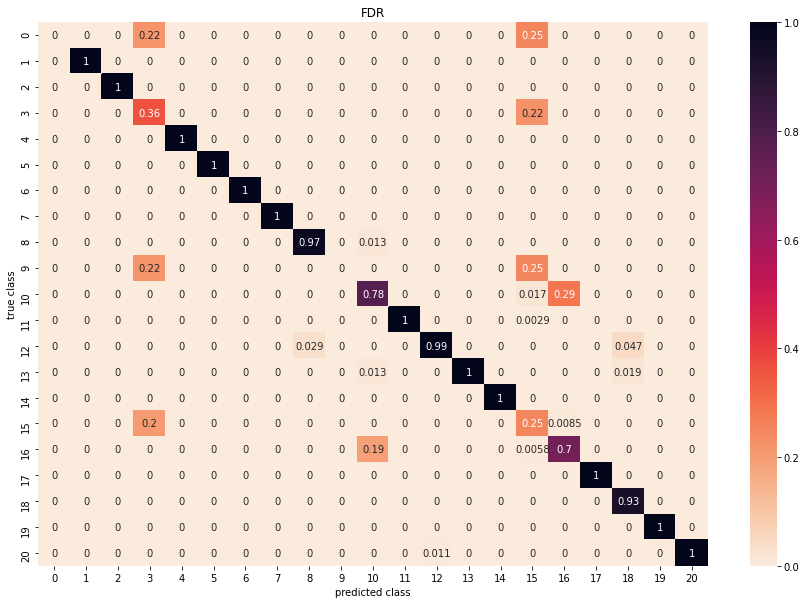

In [44]:
plt.figure(figsize=(15, 10))
plt.title("FDR")
sns.heatmap(confusion_matrix(y_true_val, y_ans_val, normalize='pred'), annot=True, cmap=sns.cm.rocket_r)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()

# ----------------------------------------------------------------------------------------

Screenshot 2020-05-11 at 16.30.53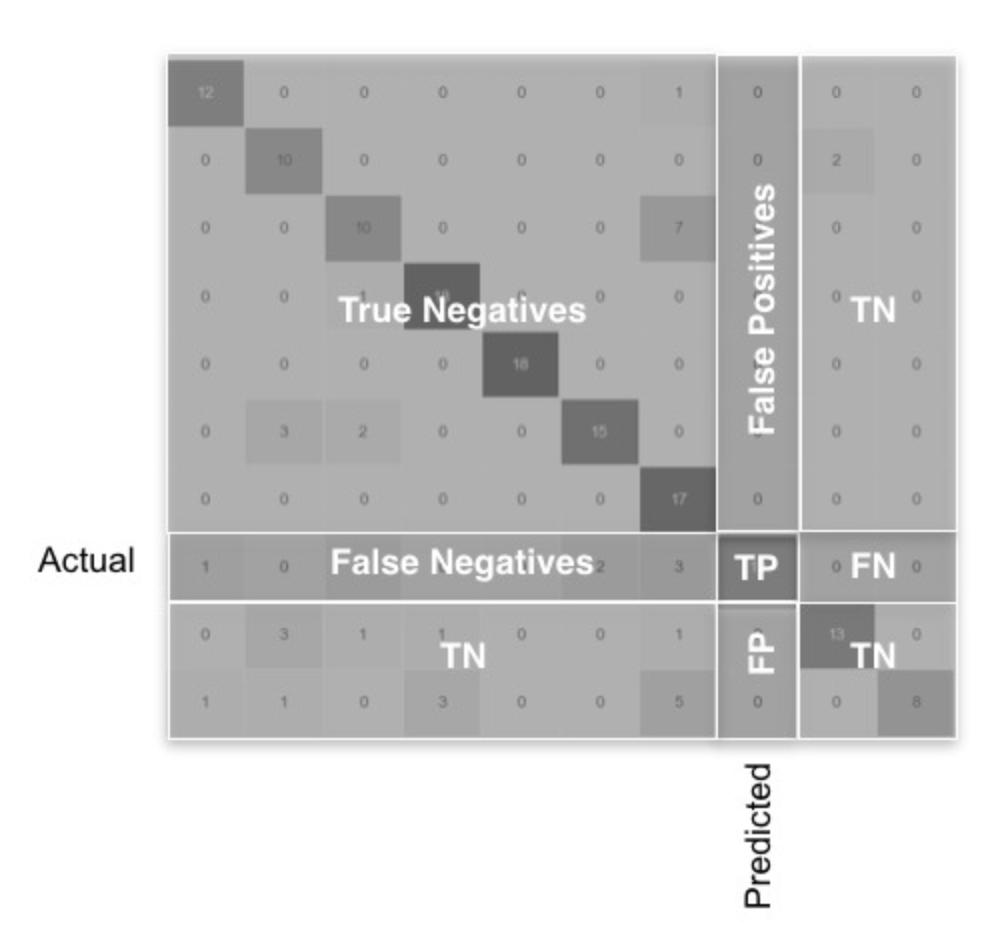

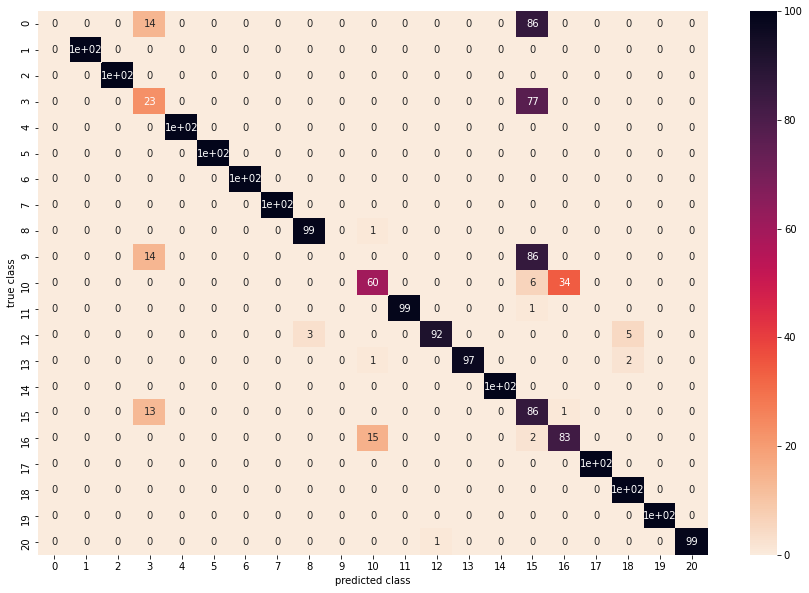

In [45]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_true_val, y_ans_val), annot=True, cmap=sns.cm.rocket_r)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()

In [55]:
def get_metrics(y_true, y_pred):
    
    conf = confusion_matrix(y_true, y_pred)
    
    FP = conf.sum(axis=0) - np.diag(conf)
    FN = conf.sum(axis=1) - np.diag(conf)
    TP = np.diag(conf)
    TN = conf.sum() - (FP + FN + TP)
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    
    return TPR, FPR, ACCURACY

def plotting(arr, name, forward=True):
    classes = np.arange(len(arr))

    norm = plt.Normalize(arr.min(), arr.max())
    
    if forward:
        colors = plt.cm.RdYlGn(norm(arr))
    else:
        colors = plt.cm.summer(norm(arr))
        
    plt.figure(figsize=(8, 5))
    plt.title(f'{name} per class')
    sns.barplot(x=classes, y=arr, palette=colors)
    plt.xticks(classes, ["fault_" + str(c) if c > 0 else "normal" for c in classes], rotation=90)
    plt.xlabel('class')
    plt.ylabel(f'{name}')
    plt.ylim(0, 1.1)
    plt.show()

In [56]:
TPR, FPR, ACCURACY = get_metrics(y_true_val, y_ans_val)

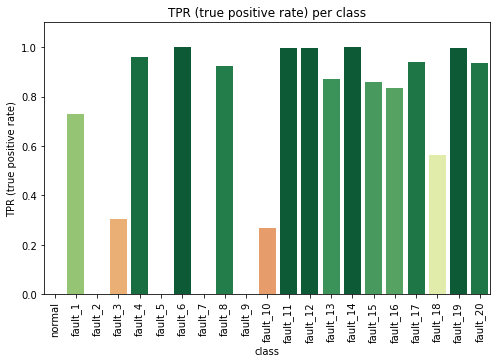

In [140]:
plotting(TPR, "TPR (true positive rate)")

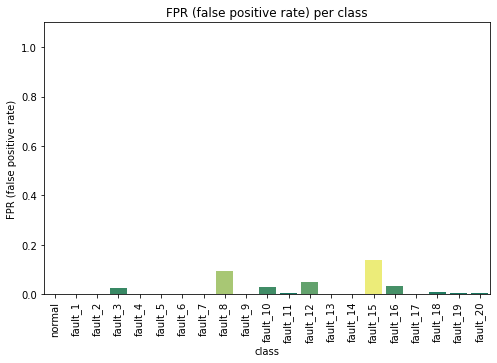

In [141]:
plotting(FPR, "FPR (false positive rate)", forward=False)

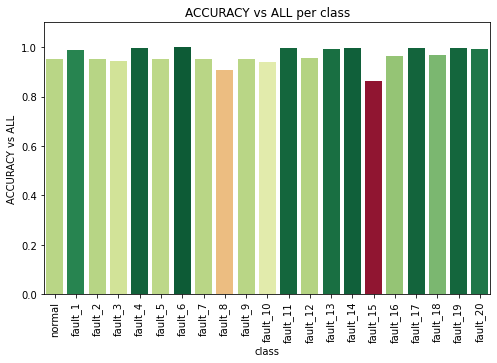

In [142]:
plotting(ACCURACY, "ACCURACY vs ALL")

### X_test

In [66]:
gc.collect()

38842

In [67]:
#reading test data in .R format
a3 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Testing.RData")

In [68]:
raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [70]:
raw_test[features] = scaler.transform(raw_test[features])

In [71]:
raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1
raw_test = raw_test.set_index('index')

In [72]:
raw_test.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
index,,,,,,,,,,,,,,,,,,,,,
0.0,0,1.0,1,-0.061905,0.201545,-0.366697,0.396960,0.672885,0.349442,-0.223455,...,0.036876,-0.280430,-0.477229,-0.047406,0.017518,0.678059,0.641891,-0.185190,0.014966,-0.693145
0.0,0,1.0,2,-0.057595,-0.504438,0.575905,0.124438,0.421859,0.709238,-0.228836,...,-0.201046,-0.283523,-0.372900,-0.042150,0.002242,-0.482106,-0.595256,-0.173439,-0.142419,-0.548871
0.0,0,1.0,3,-0.084550,-0.483398,0.012553,-0.222560,0.110240,-0.271443,-0.251702,...,-0.059070,-0.263817,-0.348612,-0.062236,0.011582,1.286104,-0.800952,-0.174777,-0.062251,0.333051
0.0,0,1.0,4,-0.063137,-0.829377,0.121173,-0.098154,0.421859,-0.105874,-0.246322,...,-0.086261,-0.279133,-0.173902,-0.082698,0.016885,0.675348,0.681334,-0.177046,-0.119325,-0.335875
0.0,0,1.0,5,-0.295060,-0.186512,0.597077,-0.170677,-0.002289,0.123376,-0.195209,...,-0.193666,-0.417724,-0.176248,-0.042244,-0.176629,0.075099,-0.747937,-0.171810,-0.087889,-0.022812


In [73]:
class DataTEST(Dataset):

    def __init__(self, X, seq_length):
    
        self.X = X
#         self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
#         self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
#         self.X = self.X.set_index('index')

        self.seq_length = seq_length
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique()
    
    def __getitem__(self, idx):

        features = self.X.loc[idx][self.features].values[160 : (161+self.seq_length), :]
        target = self.X.loc[idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [167]:
%%time

SEQ_LENGTH = [1, 5, 10, 50, 100]
metrics = dict()

for seq_length in SEQ_LENGTH:
    
    y_ans_test, y_true_test = [], []
    
    test_ds = DataTEST(raw_test, seq_length=seq_length)
    test_dl = DataLoader(test_ds, batch_size=512)

    start = time.time()
    print(f'seq_length: {seq_length}\n')

    model.eval()
    for (X_batch_test, y_batch_test) in tqdm(test_dl):
        
        print(X_batch_test.size())
        
        X_batch_lengths_test = torch.tensor([seq_length]*len(X_batch_test)).to(device)

        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

        y_pred_test = model(X_batch_test, X_batch_lengths_test)

        y_pred_prob = F.softmax(y_pred_test.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_test += y_pred_class.tolist()
        y_true_test += y_batch_test.tolist()
        
        end = time.time()
        
    TPR, FPR, ACCURACY = get_metrics(y_true_test, y_ans_test)
    
    print("Classes True", round(pd.Series(y_true_test).value_counts(normalize=True).sort_index(), 4).to_dict())
    print("Classes False", round(pd.Series(y_ans_test).value_counts(normalize=True).sort_index(), 4).to_dict())
    
    print("TPR", np.round(TPR, 4))
    print("FPR", np.round(FPR, 4))
    print("ACCURACY", np.round(ACCURACY, 4))
    
    metrics[seq_length] = [TPR, FPR, ACCURACY]
    
    print(f"seq_length time: {end - start}")  

seq_length: 1



torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([260, 2, 52])

Classes True {0: 0.0476, 1: 0.0476, 2: 0.0476, 3: 0.0476, 4: 0.0476, 5: 0.0476, 6: 0.0476, 7: 0.0476, 8: 0.0476, 9: 0.0476, 10: 0.0476, 11: 0.0476, 12: 0.0476, 13: 0.0476, 14: 0.0476, 15: 0.0476, 16: 0.0476, 17: 0.0476, 18: 0.0476, 19: 0.0476, 20: 0.0476}
Classes False {0: 0.0141, 5: 0.0288, 7: 0.0008, 10: 0.0032, 11: 0.0541, 12: 0.0001, 13: 0.0001, 14: 0.0027, 15: 0.211, 16: 0.0123, 19: 0.6729}
TPR [0.016 0.    0.    0.    0.    0.    0.    0.016 0.    0.    0.    0.
 

torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([260, 6, 52])

Classes True {0: 0.0476, 1: 0.0476, 2: 0.0476, 3: 0.0476, 4: 0.0476, 5: 0.0476, 6: 0.0476, 7: 0.0476, 8: 0.0476, 9: 0.0476, 10: 0.0476, 11: 0.0476, 12: 0.0476, 13: 0.0476, 14: 0.0476, 15: 0.0476, 16: 0.0476, 17: 0.0476, 18: 0.0476, 19: 0.0476, 20: 0.0476}
Classes False {0: 0.0016, 5: 0.0213, 7: 0.0054, 8: 0.0001, 10: 0.021, 11: 0.0866, 12: 0.0146, 13: 0.0022, 14: 0.0056, 15: 0.1509, 16: 0.0989, 18: 0.0001, 19: 0.5874, 20: 0.0044}
TPR [0.002 0.    0.    0.    0.    0.   

torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([260, 11, 52])

Classes True {0: 0.0476, 1: 0.0476, 2: 0.0476, 3: 0.0476, 4: 0.0476, 5: 0.0476, 6: 0.0476, 7: 0.0476, 8: 0.0476, 9: 0.0476, 10: 0.0476, 11: 0.0476, 12: 0.0476, 13: 0.0476, 14: 0.0476, 15: 0.0476, 16: 0.0476, 17: 0.0476, 18: 0.0476, 19: 0.0476, 20: 0.0476}
Classes False {3: 0.0008, 5: 0.0186, 7: 0.0035, 8: 0.0004, 9: 0.0001, 10: 0.0681, 11: 0.0996, 12: 0.0295, 13: 0.0025, 14: 0.0119, 15: 0.3619, 16: 0.0892, 17: 0.0003, 18: 0.0008, 19: 0.3031, 20: 0.0

torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([260, 51, 52])

Classes True {0: 0.0476, 1: 0.0476, 2: 0.0476, 3: 0.0476, 4: 0.0476, 5: 0.0476, 6: 0.0476, 7: 0.0476, 8: 0.0476, 9: 0.0476, 10: 0.0476, 11: 0.0476, 12: 0.0476, 13: 0.0476, 14: 0.0476, 15: 0.0476, 16: 0.0476, 17: 0.0476, 18: 0.0476, 19: 0.0476, 20: 0.0476}
Classes False {0: 0.0009, 1: 0.0005, 3: 0.0285, 4: 0.0325, 5: 0.005, 6: 0.0248, 8: 0.1469, 9: 0.0009, 10: 0.0542, 11: 0.0771, 12: 0.0802, 13: 0.0156, 14: 0.0529, 15: 0.3008, 16: 0.0643, 17: 0.0187,

torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([260, 101, 52])

Classes True {0: 0.0476, 1: 0.0476, 2: 0.0476, 3: 0.0476, 4: 0.0476, 5: 0.0476, 6: 0.0476, 7: 0.0476, 8: 0.0476, 9: 0.0476, 10: 0.0476, 11: 0.0476, 12: 0.0476, 13: 0.0476, 14: 0.0476, 15: 0.0476, 16: 0.0476, 17: 0.0476, 18: 0.0476, 19: 0.0476, 20: 0.0476}
Classes False {0: 0.0001, 1: 0.0347, 3: 0.0367, 4: 0.0462, 5: 0.0016, 6: 0.0476, 7: 0.0002, 8: 0.1326, 9: 0.0003, 10: 0.0392, 11: 0.0508, 12: 0.0935, 13: 0.0415, 14: 0.0496, 15

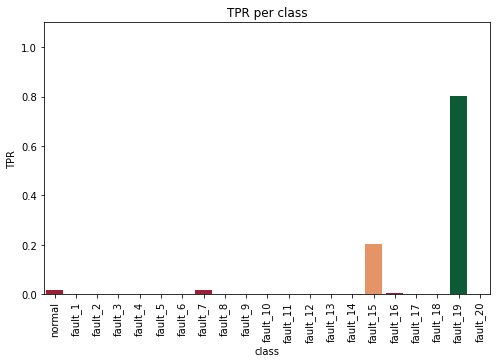

In [143]:
plotting(metrics[1][0], "TPR")

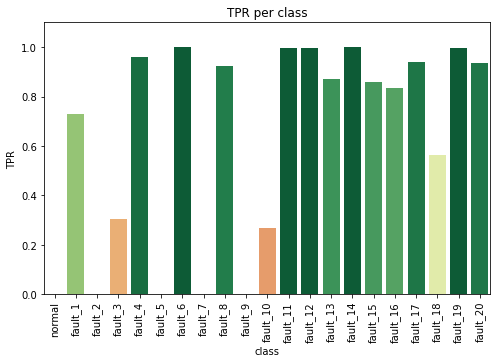

In [144]:
plotting(metrics[100][0], "TPR")

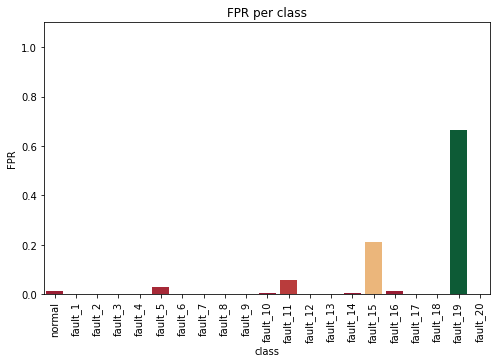

In [145]:
plotting(metrics[1][1], "FPR")

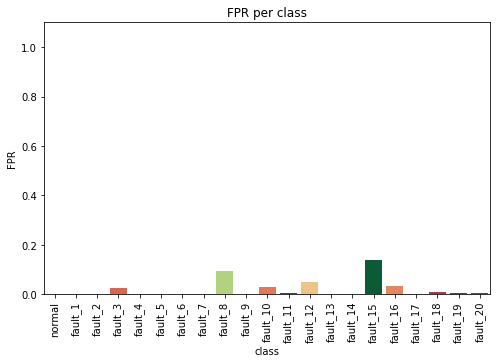

In [146]:
plotting(metrics[100][1], "FPR")

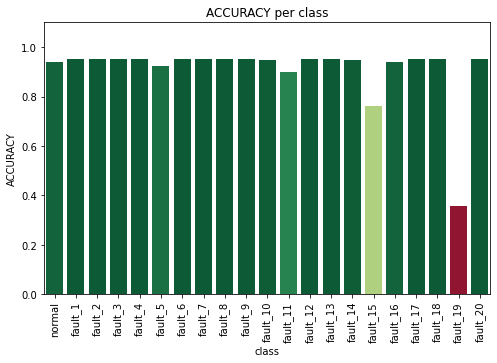

In [147]:
plotting(metrics[1][2], "ACCURACY")

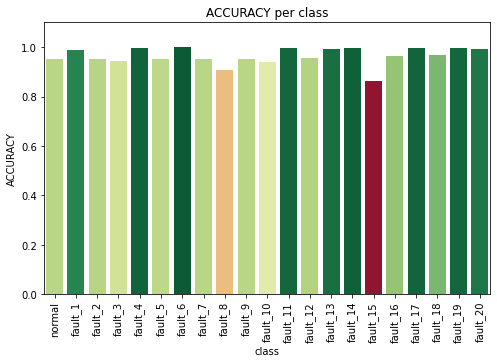

In [148]:
plotting(metrics[100][2], "ACCURACY")

In [ ]:
class TwinModel(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        self.lstm_1 = nn.LSTM(
                        input_size=self.input_size[0], 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.lstm_2 = nn.LSTM(
                        input_size=self.input_size[1],
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=2*self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
        
        x_1 = x[:, :, :41]
        x_2 = x[:, :, 41:]
        
        x_1, _ = self.lstm_1(x_1)
        x_2, __ = self.lstm_2(x_2)
        
        x_3 = torch.cat((x_1[:, -1], x_2[:, -1]), dim=-1)
        
        x = self.head(x_3)
        
        return x